###Adversarial Retraining against Untargeted FGSM Attacks: For this step, you can assume ε = 10 throughout. To defend against adversarial perturbations, the defender adversarially perturbs each image in her training set using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their correct labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the adversarially retrained DNN.


In [3]:
import tensorflow as tf

First extracting the data (copying code from example collab)

In [22]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [41]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10,activation='softmax')
])
predictions = model(x_train[:1]).numpy()
predictions

array([[0.09248519, 0.19016561, 0.09309188, 0.04964913, 0.0495783 ,
        0.11208337, 0.10921102, 0.08966512, 0.06469159, 0.14937878]],
      dtype=float32)

In [42]:
tf.nn.softmax(predictions).numpy()

array([[0.09916443, 0.10933973, 0.0992246 , 0.09500632, 0.09499959,
        0.10112704, 0.10083698, 0.09888518, 0.09644625, 0.10496983]],
      dtype=float32)

Because of disadv. we are using Sparse Categorical Cross entropy

In [43]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [44]:
loss_fn(y_train[:1], predictions).numpy()

2.2913778

In [45]:
import numpy as np

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

def modd(x):
  return (x+1)%10
moddV=np.vectorize(modd)


In [46]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5905 - accuracy: 0.8877
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5225 - accuracy: 0.9444
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5093 - accuracy: 0.9562
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5020 - accuracy: 0.9627
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4971 - accuracy: 0.9669


In [47]:
model.evaluate(x_test,  y_test, verbose=2)
print(y_test.shape)
print(x_test.shape)

313/313 - 0s - loss: 1.4966 - accuracy: 0.9671
(10000,)
(10000, 28, 28)


In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Adversarial Retraining against Untargeted FGSM Attacks: For this step, you can assume ε = 10 throughout. To defend against adversarial perturbations, the defender adversarially perturbs each image in her training set using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their correct labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the adversarially retrained DNN.

In [59]:
loss_object=tf.keras.losses.CategoricalCrossentropy()

#As I'm feeding in onehotcode form I'm using the "tf.keras.losses.CategoricalCrossentropy()"

#loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def advPattern(x_test, input_label):
  input_image=tf.convert_to_tensor(x_test)
  #
  input_label = to_categorical(input_label)
  with tf.GradientTape() as tp:
    tp.watch(input_image)

    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  # getting d gradients of loss w.r.t to the input image.
  gradient = tp.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad
e= [10/255]

from keras.utils import to_categorical

# make the model and load the training dataset.

#y_test = to_categorical(y_test)

In [50]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
x_test[0].shape
def dispImgs(image, description):
  ADVconfidence = model.predict(image)
  model.evaluate(image,  description, verbose=2)
  #for ia in range(len(ADVconfidence)):
  for ia in range(0,10):
    # Just displaying 10 images
    plt.figure()
    plt.imshow(image[ia])
    plt.title(' \n Number is {} and after Adversarial attack it is labbeled as {} '.format(str(description[ia]), np.argmax(ADVconfidence[ia]*100)))
    plt.show()

In [51]:

print(x_test.shape)
print(type(y_test))
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)


def modd(x):
  return (x+1)%10
moddV=np.vectorize(modd)
ya_test=moddV(y_test)
print(type(ya_test))
print(ya_test.shape)
ya_test.reshape(10000,1)
perturbations=advPattern(x_test, y_test)
adv_x_test=[]
for i, eps in enumerate(e):
  #print(x_test.shape)
  
  img_tensor=tf.convert_to_tensor(x_test)
  #print(img_tensor.shape)
  #print(perturbations.shape)
  adv_x = img_tensor + eps*perturbations
  #print(adv_x.shape)
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  adv_x_test.append(adv_x)

#print(len(adv_x_test)) Length is 7
#for ii in range(len(adv_x_test)):
for ii in range(0,1):
  #dispImgs(adv_x_test[ii], y_test)
  print(len(adv_x_test))


(10000, 28, 28)
<class 'numpy.ndarray'>
(10000,)
(60000, 28, 28)
(60000,)
<class 'numpy.ndarray'>
(10000,)
1


(10000,)
(10000, 28, 28)
313/313 [==============================] - 0s 2ms/step - loss: 1.6882 - accuracy: 0.7805


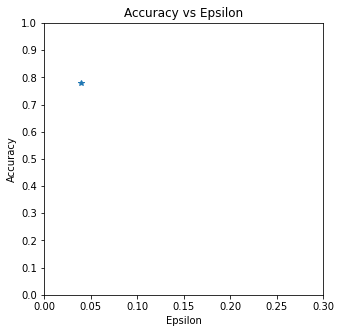

In [52]:
print(y_test.shape)
print(adv_x_test[0].shape)
advAccu=[]
'''
for advimg in adv_x_test:
  advY=model.predict(advimg)
  advyLabels.append(advY)
print(len(advyLabels))
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_duplicate=y_test
y_duplicate = to_categorical(y_duplicate)

for y_predicted in advyLabels:
  print(y_predicted.shape)
  print(y_duplicate.shape)
  matrix=classification_report(y_duplicate, y_predicted)
  cm=pd.DataFrame(matrix)
  print(cm)'''

for advimg in adv_x_test:
  MetricsDict=model.evaluate(advimg,y_test,return_dict=True)
  advAccu.append(MetricsDict['accuracy'])
plt.figure(figsize=(5,5))
plt.plot(e, advAccu, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [53]:
#type(new_x)
new_x=tf.concat([x_train, advimg], 0)
#new_x=+
new_x.shape

TensorShape([70000, 28, 28])

In [54]:
#new_y_test=y_test+y_test
new_y=tf.concat([y_train, y_test], 0)

In [55]:
Retainedmodel = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10,activation='softmax')
])

In [56]:

Retainedmodel.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [57]:
Retainedmodel.fit(new_x, new_y, epochs=5)

Epoch 1/5
2188/2188 [==============================] - 4s 2ms/step - loss: 1.5767 - accuracy: 0.9006
Epoch 2/5
2188/2188 [==============================] - 4s 2ms/step - loss: 1.5205 - accuracy: 0.9467
Epoch 3/5
2188/2188 [==============================] - 4s 2ms/step - loss: 1.5072 - accuracy: 0.9575
Epoch 4/5
2188/2188 [==============================] - 4s 2ms/step - loss: 1.4992 - accuracy: 0.9649
Epoch 5/5
2188/2188 [==============================] - 4s 2ms/step - loss: 1.4947 - accuracy: 0.9692


ReTraining completed now Attacking again

313/313 [==============================] - 0s 1ms/step - loss: 1.4710 - accuracy: 0.9912


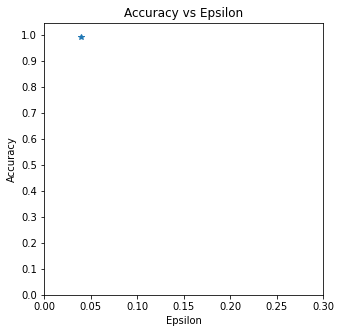

In [58]:
advAccu=[]

for advimg in adv_x_test:
  MetricsDict=Retainedmodel.evaluate(advimg,y_test,return_dict=True)
  advAccu.append(MetricsDict['accuracy'])
plt.figure(figsize=(5,5))
plt.plot(e, advAccu, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

So the original model has less accuracy and retrained model has 99 accuracy(which is way more than original model), hence proved that retraining will work